# Manual Integration Workbook

* this workbook is run once for each sample.
* change `path_samples` (cell 2) to wherever you unzipped the folder on your local machine
* change `sample_name`, `m` and `c` parameters (gradient and intercept, respectively) in cell 5, then run cell 6 to check the visualization. Run cell 5 and 6 as many times as you like until you get a fit that you like, then run cell 7 (last cell) to calculate conc based on AUC.

In [1]:
# CELL 1
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import os
import json
import time
import re
import math
import pickle

from nmr_targeted_utils import *
from nmr_fitting_funcs import *


# Admin Section - Make `.pkl` File, `blue_m1_dict.pkl`

In [8]:
# load data
blue_m1_pkl_path = "blue_m1_dict_scratch.pkl"
path_samples = "/Users/dteng/Documents/zdata/nmr/J202208B_pro_survey/J202208B_n1214_csvs"
multiplets_ls = [[1.9,2.15], [2.295, 2.403], [3.25, 3.5],[4.1, 4.2]]
mcoords = multiplets_ls[1]
ref_pk_window = [-0.2, 0.2]
ref_pk_tolerance_window = [0,0]
# value of search_region_padding_size doesn't really matter, 
# since manual integ will sort this out anyway
search_region_padding_size = 0.01
mcoords_xl = [min(mcoords)-search_region_padding_size, 
              max(mcoords)+search_region_padding_size]

requested_samplenames_ls = ["AE60332", "42DEG463"]

df_dict = {}
for fn in os.listdir(path_samples):
    if (".csv" in fn) and (fn.replace(".csv", "") in requested_samplenames_ls):
        k = fn.replace(".csv", "")
        dt = pd.read_csv(os.path.join(path_samples, fn))
        dt = adjust_to_ref_peak(dt, ref_pk_window, ref_pk_tolerance_window)
        # save whole spectra
        df_dict[k] = dt

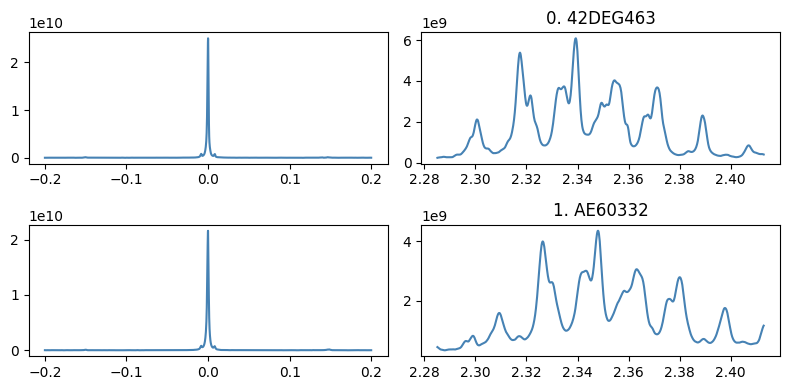

In [9]:
# visual sanity check of all blue M1s
fig, ax = plt.subplots(nrows=len(df_dict), 
                       ncols=2, 
                       figsize=(8, 2*len(df_dict))
                      )

i = 0
for k in sorted(list(df_dict.keys())):
    # plot ref_pk
    df = df_dict[k].copy()
    dt = df.loc[(df["ppm"]>min(ref_pk_window)) & (df["ppm"]<max(ref_pk_window))].copy()
    ax[i, 0].plot(dt.ppm.values, dt.intensity.values, c="steelblue")
    
    # plot multiplet
    df = df_dict[k].copy()
    dt = df.loc[(df["ppm"]>min(mcoords_xl)) & (df["ppm"]<max(mcoords_xl))].copy()
    ax[i,1].plot(dt.ppm.values, dt.intensity.values, c="steelblue")
    ax[i,1].set_title(f"{i}. {k}")
    i += 1

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()


In [10]:
# create blue_m1_dict
blue_m1_dict = {}
for k, dt in df_dict.items():
    # save ref_pk
    dt2 = dt.copy()
    dt2 = dt2.loc[(dt2["ppm"] > min(ref_pk_window)) & (dt2["ppm"] < max(ref_pk_window))].copy()
    temp_dict = {"ref_pk": dt2}
    
    # save multiplet1
    dt2 = dt.copy()
    dt2 = dt2.loc[(dt2["ppm"] > min(mcoords_xl)) & (dt2["ppm"] < max(mcoords_xl))].copy()
    temp_dict["multiplet_1"] = dt2
    
    # save
    blue_m1_dict[k] = temp_dict

# save as .pkl
with open(blue_m1_pkl_path, 'wb') as f:
    pickle.dump(blue_m1_dict, f)

print(f"Saved as {blue_m1_pkl_path}")

Saved as blue_m1_dict_scratch.pkl


# User Section - Run, With `.pkl` File Already Created

In [13]:
# CELL 2

# ===== params =====
template_path = "lproline_ph3.csv"
# change path_samples as required. Use the full path, which is easiest obtained from the topbar in Win Explorer
path_samples = "/Users/dteng/Documents/zdata/nmr/manual-processing-14feb2024_pkg/manual-processing-14feb2024_csvs"
bs_grad_path = "bootstrap_results_12sep2023.csv"
blue_m1_pkl_path = "blue_m1_dict_scratch.pkl"

multiplets_ls = [[1.9,2.15], [2.295, 2.403], [3.25, 3.5],[4.1, 4.2]]
ref_pk_window = [-0.2, 0.2]
ref_pk_tolerance_window = [0,0]
search_region_padding_size = 0.02

# ========== load data ==========
# load STD template(s)
template_df = pd.read_csv(template_path)
template_df = adjust_to_ref_peak(template_df, ref_pk_window, ref_pk_tolerance_window)

# load blue_m1_dict
with open(blue_m1_pkl_path, 'rb') as f:
    blue_m1_dict = pickle.load(f)

# load sample data
# df_dict = {}
# for fn in os.listdir(path_samples):
#     if ".csv" in fn:
#         k = fn.replace(".csv", "")
#         df_dict[k] = pd.read_csv(os.path.join(path_samples, fn))

# load gradient data
grad_df = pd.read_csv(bs_grad_path)

# get reds
red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

# print out list of sample names, to copy-paste into cell 5
print(f"Sample names found in {blue_m1_pkl_path}:")
for k in sorted(list(blue_m1_dict.keys())):
    print(k)

Sample names found in blue_m1_dict_scratch.pkl:
42DEG463
AE60332


### Toggle Constant And Coefficient

Change gradient (`m`) and intercept (`c`) as needed, iterating until the blue (`sample`) and red (`std`) fit in the plot in the cell one after this one. 

In [20]:
# CELL 5

# pick a sample
sample_name = "AE60332"
# gradient, change as required
m = 0.7829343286693756
# intercept, change as required
c = 505136807.8076135
# x_shift applied to red, change as required
x_shift = 0.0045

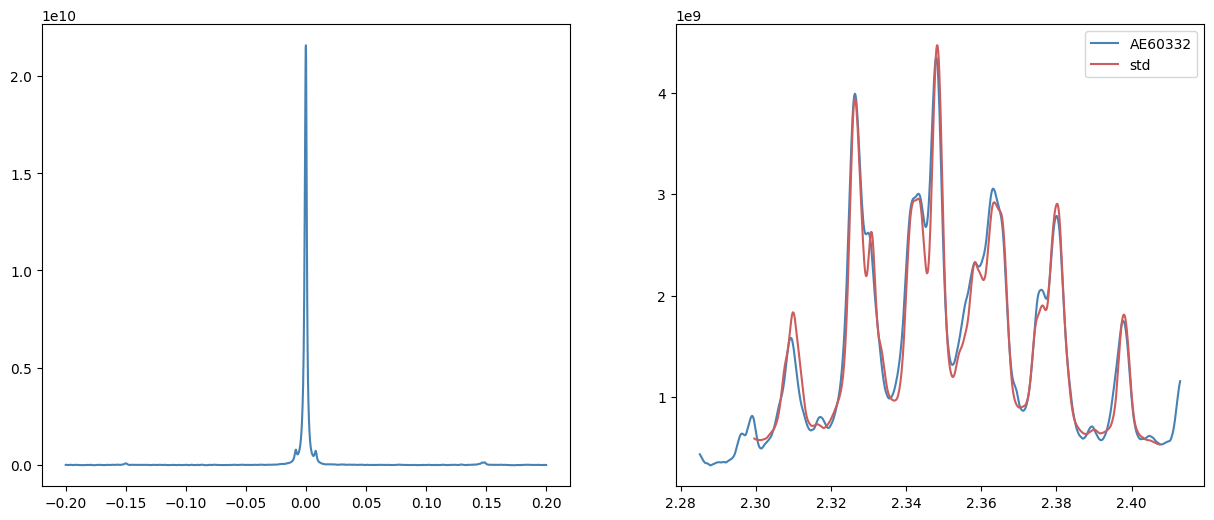

In [21]:
# CELL 6 - show plot

blue_m1_dt = blue_m1_dict[sample_name].copy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(blue_m1_dt["ref_pk"].ppm.values, 
           blue_m1_dt["ref_pk"].intensity.values, 
           c="steelblue")
ax[1].plot(blue_m1_dt["multiplet_1"].ppm.values, 
           blue_m1_dt["multiplet_1"].intensity.values, 
           c="steelblue", 
           label=sample_name)
ax[1].plot(red_dt.ppm.values+x_shift, (red_dt.intensity.values*m)+c, c="indianred", label="std")
plt.legend()

plt.show()

In [23]:
# CELL 7

# print out AUC
auc = np.trapz((red_dt.intensity.values*m)+c)
print(auc)

conc_ls = grad_df["V1"].values * auc
print(f"conc: average = {np.average(conc_ls)}, sd = {np.std(conc_ls, ddof=1)}")

1076676535360.425
conc: average = 1376.767145511907, sd = 8.59651302307148
